Here let's fine tune our whole prediction pipeline.

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import joblib
import itertools
import compose
import json
%matplotlib inline

from scipy.stats import (
    randint, 
    expon, 
    reciprocal, 
    uniform, 
    norm,
)

import sys
import os
import warnings
sys.path.append(os.path.join(
    os.path.abspath(os.path.pardir), 'src'
))

import nzcompetition
from nzcompetition.preparation import make_prep_pipeline
from nzcompetition.plots import plot_train_pred, plot_pred_distribution

from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import (
    RandomForestRegressor, 
    AdaBoostRegressor
)
from sklearn.model_selection import (
    cross_val_score, 
    GridSearchCV, 
    RandomizedSearchCV
)

import xgboost

from libdl.dl import dl

y_col = 'performance'
y_col_raw = 'TOM Wash PT Model X'
# for plotting
lim=[0, 1.5]

random_state=190624

# Raw Data

In [2]:
X_train, y, X_val = nzcompetition.get_raw_data(target=y_col)
X_train, y = nzcompetition.drop_dup(X_train, y)
X_train, X_val = nzcompetition.drop_tom(X_train), nzcompetition.drop_tom(X_val)
X_test = nzcompetition.get_test_data()
y_val = (
    dl.datasets.get(id='nz_kaggle').files.get(id='validation').as_df()
    .set_index(["Organism Code", "purifiedsample_sequoia_identifier"])
    [y_col_raw]
)
X = pd.concat([X_train, X_val])
y = pd.concat([y, y_val])

# Prep Data

Here I'll use the prep code `TTF`, `TFF` and `FTF`.

In [4]:
%%time
prepDct = dict.fromkeys([
    (True, True), 
    (True, False), 
    (False, True)
])

with warnings.catch_warnings():
    warnings.simplefilter('ignore', category=RuntimeWarning)
    for seqmut, seqprot in prepDct.keys():
        prep_pipe = make_prep_pipeline(seqmut, seqprot, False)
        X_train_prep = prep_pipe.fit_transform(X)
        X_test_prep = prep_pipe.transform(X_test)
        prepDct[seqmut, seqprot] = (X_train_prep, X_test_prep)
        print('Finished {}{}'.format(seqmut, seqprot))

Finished FalseTrue
Finished TrueFalse
Finished TrueTrue
CPU times: user 21.8 s, sys: 674 ms, total: 22.5 s
Wall time: 45.6 s


In [6]:
evaldf = pd.DataFrame(
    np.zeros((6, 4)), 
    index=pd.MultiIndex(
        levels = [
            [True, False], 
            [True, False], 
            ['adaboost', 'xgboost']
        ], 
        codes = [
            [0, 0, 1, 1, 0, 0],
            [0, 0, 0, 0, 1, 1],
            [0, 1, 0, 1, 0, 1]
        ]
    ), 
    columns=['model', 'mse_train', 'mean_mse_cv5', 'mse_test']
)

In [7]:
evaldf['model'] = np.nan
evaldf

model  mse_train  mean_mse_cv5  mse_test
True  True  adaboost    NaN        0.0           0.0       0.0
            xgboost     NaN        0.0           0.0       0.0
False True  adaboost    NaN        0.0           0.0       0.0
            xgboost     NaN        0.0           0.0       0.0
True  False adaboost    NaN        0.0           0.0       0.0
            xgboost     NaN        0.0           0.0       0.0

# Modeling

In [3]:
ada_reg = AdaBoostRegressor(base_estimator=DecisionTreeRegressor(), random_state=random_state)
xgb_reg = xgboost.XGBRegressor(objective='reg:squarederror', random_state=random_state)

### Adaboost

In [10]:
%%time
for seqmut, seqprot in prepDct.keys():
    X_train_prep, _ = prepDct[seqmut, seqprot]
    param_dist = dict(
        base_estimator__max_depth=randint(3, 6),
        base_estimator__max_leaf_nodes=randint(20, 40), 
        base_estimator__max_features=uniform(0.2, 0.8), 
        learning_rate=uniform(0.5, 1), 
        n_estimators=randint(30, 70), 
    )

    ada_search = RandomizedSearchCV(
        ada_reg, 
        param_distributions=param_dist, 
        n_iter=5000, 
        scoring='neg_mean_squared_error', 
        n_jobs=15, 
        cv=5, 
        verbose=0, 
        iid=False, 
    )
    ada_search.fit(X_train_prep, y)
    evaldf.loc[(seqmut, seqprot, 'adaboost'), 'model'] = json.dumps(ada_search.best_params_)
    evaldf.loc[(seqmut, seqprot, 'adaboost'), 'mean_mse_cv5'] = ada_search.best_score_
    evaldf.loc[(seqmut, seqprot, 'adaboost'), 'mse_train'] = mean_squared_error(y, ada_search.predict(X_train_prep))

    print('Finished {}-{}'.format(seqmut, seqprot))

/z/datalake/virtual_envs/current/Ubuntu16.04/lib/python3.5/site-packages/IPython/core/interactiveshell.py:3326: PerformanceWarning: indexing past lexsort depth may impact performance.
  exec(code_obj, self.user_global_ns, self.user_ns)
/z/datalake/virtual_envs/current/Ubuntu16.04/lib/python3.5/site-packages/IPython/core/interactiveshell.py:3326: PerformanceWarning: indexing past lexsort depth may impact performance.
  exec(code_obj, self.user_global_ns, self.user_ns)


Finished False-True


/z/datalake/virtual_envs/current/Ubuntu16.04/lib/python3.5/site-packages/IPython/core/interactiveshell.py:3326: PerformanceWarning: indexing past lexsort depth may impact performance.
  exec(code_obj, self.user_global_ns, self.user_ns)
/z/datalake/virtual_envs/current/Ubuntu16.04/lib/python3.5/site-packages/IPython/core/interactiveshell.py:3326: PerformanceWarning: indexing past lexsort depth may impact performance.
  exec(code_obj, self.user_global_ns, self.user_ns)


Finished True-False
Finished True-True
CPU times: user 3min 35s, sys: 6.18 s, total: 3min 41s
Wall time: 10min 21s


/z/datalake/virtual_envs/current/Ubuntu16.04/lib/python3.5/site-packages/IPython/core/interactiveshell.py:3326: PerformanceWarning: indexing past lexsort depth may impact performance.
  exec(code_obj, self.user_global_ns, self.user_ns)
/z/datalake/virtual_envs/current/Ubuntu16.04/lib/python3.5/site-packages/IPython/core/interactiveshell.py:3326: PerformanceWarning: indexing past lexsort depth may impact performance.
  exec(code_obj, self.user_global_ns, self.user_ns)


### Xgboost

In [16]:
%%time
for seqmut, seqprot in prepDct.keys():
    X_train_prep, _ = prepDct[seqmut, seqprot]
    param_dist = dict(
        max_depth=[3,4,5], 
        learning_rate = uniform(0.05, 0.1), 
        subsample=uniform(0.3, 0.7), 
        reg_alpha=uniform(0, 1), 
        reg_lambda=uniform(0, 1), 
        gamma=uniform(0, 0.1), 
        colsample_bytree=uniform(0.3, 0.7), 
    )

    xgb_search = RandomizedSearchCV(
        xgb_reg, 
        param_distributions=param_dist, 
        n_iter=7000, 
        scoring='neg_mean_squared_error', 
        n_jobs=15, 
        cv=5, 
        verbose=0, 
        iid=False, 
    )
    xgb_search.fit(X_train_prep, y)
    evaldf.loc[(seqmut, seqprot, 'xgboost'), 'model'] = json.dumps(xgb_search.best_params_)
    evaldf.loc[(seqmut, seqprot, 'xgboost'), 'mean_mse_cv5'] = xgb_search.best_score_
    evaldf.loc[(seqmut, seqprot, 'xgboost'), 'mse_train'] = mean_squared_error(y, xgb_search.predict(X_train_prep))

    print('Finished {}-{}'.format(seqmut, seqprot))

/z/datalake/virtual_envs/current/Ubuntu16.04/lib/python3.5/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/z/datalake/virtual_envs/current/Ubuntu16.04/lib/python3.5/site-packages/IPython/core/interactiveshell.py:3326: PerformanceWarning: indexing past lexsort depth may impact performance.
  exec(code_obj, self.user_global_ns, self.user_ns)
/z/datalake/virtual_envs/current/Ubuntu16.04/lib/python3.5/site-packages/IPython/core/interactiveshell.py:3326: PerformanceWarning: indexing past lexsort depth may impact performance.
  exec(code_obj, self.user_global_ns, self.user_ns)


Finished False-True


/z/datalake/virtual_envs/current/Ubuntu16.04/lib/python3.5/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/z/datalake/virtual_envs/current/Ubuntu16.04/lib/python3.5/site-packages/IPython/core/interactiveshell.py:3326: PerformanceWarning: indexing past lexsort depth may impact performance.
  exec(code_obj, self.user_global_ns, self.user_ns)


Finished True-False
Finished True-True
CPU times: user 3min 4s, sys: 4 s, total: 3min 8s
Wall time: 7min 49s


/z/datalake/virtual_envs/current/Ubuntu16.04/lib/python3.5/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/z/datalake/virtual_envs/current/Ubuntu16.04/lib/python3.5/site-packages/IPython/core/interactiveshell.py:3326: PerformanceWarning: indexing past lexsort depth may impact performance.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [18]:
evaldf

model  \
True  True  adaboost  {"n_estimators": 56, "base_estimator__max_feat...   
            xgboost   {"max_depth": 4, "reg_alpha": 0.32533050817493...   
False True  adaboost  {"n_estimators": 39, "base_estimator__max_feat...   
            xgboost   {"max_depth": 5, "reg_alpha": 0.47442532784835...   
True  False adaboost  {"n_estimators": 31, "base_estimator__max_feat...   
            xgboost   {"max_depth": 5, "reg_alpha": 0.24347386411504...   

                      mse_train  mean_mse_cv5  mse_test  
True  True  adaboost   0.004647     -0.039234       0.0  
            xgboost    0.004697     -0.037822       0.0  
False True  adaboost   0.004187     -0.039194       0.0  
            xgboost    0.006143     -0.036342       0.0  
True  False adaboost   0.006540     -0.039079       0.0  
            xgboost    0.006776     -0.037783       0.0

In [19]:
evaldf.to_csv('../documents/perf_eval.csv')

### Final prediction

In [21]:
idx = evaldf['mean_mse_cv5'].idxmax()
params = json.loads(evaldf.loc[idx, 'model'])
print(idx)
print(params)

(False, True, 'xgboost')
{'max_depth': 5, 'reg_alpha': 0.47442532784835, 'gamma': 0.016388900945684393, 'subsample': 0.39763183078870307, 'learning_rate': 0.14191023261238345, 'reg_lambda': 0.9998915594980481, 'colsample_bytree': 0.9158018068276232}


Below is where the typo happened. It is because I copied cells from somewhere else but forgot to examine variable names before running them.

In [22]:
xgb_reg = xgboost.XGBRegressor(
    objective='reg:squarederror', 
    random_state=random_state, 
    **params
)
X_train_prep, X_test_prep = prepDct[(False, True)]
ada_reg.fit(X_train_prep, y)

AdaBoostRegressor(base_estimator=DecisionTreeRegressor(criterion='mse',
                                                       max_depth=None,
                                                       max_features=None,
                                                       max_leaf_nodes=None,
                                                       min_impurity_decrease=0.0,
                                                       min_impurity_split=None,
                                                       min_samples_leaf=1,
                                                       min_samples_split=2,
                                                       min_weight_fraction_leaf=0.0,
                                                       presort=False,
                                                       random_state=None,
                                                       splitter='best'),
                  learning_rate=1.0, loss='linear', n_estimators=50,
                  rando

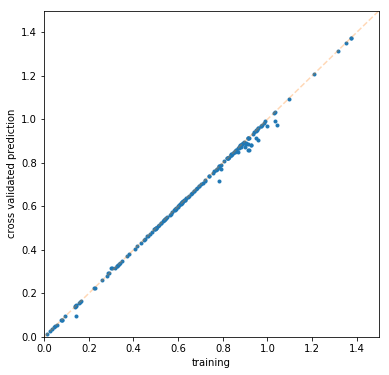

In [23]:
plot_train_pred(y, ada_reg.predict(X_train_prep), lim)

In [24]:
pd.DataFrame(
    ada_reg.predict(X_test_prep), 
    index=X_test.droplevel('Organism Code').index, 
    columns=['pred'], 
    dtype='float'
).to_csv('../output/submission/perf_FTF10N_xgboost.csv')
joblib.dump(ada_reg, '../models/submission/perf_FTF10N_xgboost.pkl')

['../models/submission/perf_FTF10N_xgboost.pkl']

This one got an MSE `0.0107` in test set.

---

In [7]:
xgb_reg = xgboost.XGBRegressor(
    objective='reg:squarederror', 
    random_state=random_state, 
    **params
)
X_train_prep, X_test_prep = prepDct[(False, True)]
xgb_reg.fit(X_train_prep, y)

/z/datalake/virtual_envs/current/Ubuntu16.04/lib/python3.5/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.9158018068276232,
             gamma=0.016388900945684393, importance_type='gain',
             learning_rate=0.14191023261238345, max_delta_step=0, max_depth=5,
             min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
             nthread=None, objective='reg:squarederror', random_state=190624,
             reg_alpha=0.47442532784835, reg_lambda=0.9998915594980481,
             scale_pos_weight=1, seed=None, silent=None,
             subsample=0.39763183078870307, verbosity=1)

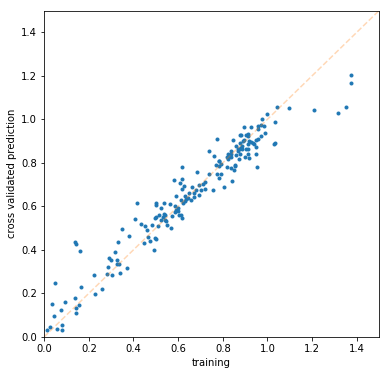

In [8]:
plot_train_pred(y, xgb_reg.predict(X_train_prep), lim)

In [21]:
from sklearn.model_selection import cross_val_predict

In [9]:
ada_reg.fit(X_train_prep, y)

AdaBoostRegressor(base_estimator=DecisionTreeRegressor(criterion='mse',
                                                       max_depth=None,
                                                       max_features=None,
                                                       max_leaf_nodes=None,
                                                       min_impurity_decrease=0.0,
                                                       min_impurity_split=None,
                                                       min_samples_leaf=1,
                                                       min_samples_split=2,
                                                       min_weight_fraction_leaf=0.0,
                                                       presort=False,
                                                       random_state=None,
                                                       splitter='best'),
                  learning_rate=1.0, loss='linear', n_estimators=50,
                  rando

In [19]:
cvscores = cross_val_score(ada_reg, X_train_prep, y, cv=5, scoring='neg_mean_squared_error')
print(cvscores, np.mean(cvscores))

[-0.05863283 -0.03924445 -0.04397346 -0.02817413 -0.05228864] -0.044462699881622006


In [20]:
cvscores = cross_val_score(xgb_reg, X_train_prep, y, cv=5, scoring='neg_mean_squared_error')
print(cvscores, np.mean(cvscores))

/z/datalake/virtual_envs/current/Ubuntu16.04/lib/python3.5/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/z/datalake/virtual_envs/current/Ubuntu16.04/lib/python3.5/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/z/datalake/virtual_envs/current/Ubuntu16.04/lib/python3.5/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[-0.04949921 -0.02909358 -0.02684971 -0.02574962 -0.05516965] -0.037272352996776045


/z/datalake/virtual_envs/current/Ubuntu16.04/lib/python3.5/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/z/datalake/virtual_envs/current/Ubuntu16.04/lib/python3.5/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
